<a href="https://colab.research.google.com/github/nikitaker/Q-learning/blob/master/Programming_students_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание на программирование

Зададим гиперпараметры модели

In [0]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 3 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды) 
lr_rate = 0.9 #Коэффициент скорости обучения альфа

In [44]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFFHH
FFFFFF
FFFFFF
FFFFFF
FFFFFH
HFHHFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

In [0]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    target = reward + gamma*np.max(Q[state2])
    error = target - Q[state, action]
    Q[state, action] += lr_rate*error

In [0]:
from tqdm import tqdm
# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
won = 0
isFirst = True
streak = 0
Q = np.zeros((env.observation_space.n, env.action_space.n))
#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        
        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)
        
        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, done)

        state = state2

        if done:
          
          if reward == 1:
            won += 1
            if isFirst:
              streak += 1
          else:
            streak = 0

          if streak == 5:
            streak_num = game + 1
            isFirst = False
            streak = 0
          
          break


In [76]:
print("Количество побед в серии из 10 000 игр: ", won)
print("Пять побед подряд впервые было одержано в игре ", streak_num)


Количество побед в серии из 10 000 игр:  9116
Пять побед подряд впервые было одержано в игре  31


In [48]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


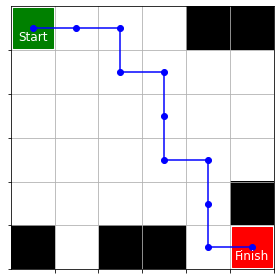

In [49]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  

#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

In [0]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, action2, done):
    if done:
      Q[state, action] += lr_rate * ( reward  - Q[state, action] )
    else:
      Q[state, action] += lr_rate * ( reward + (gamma * Q[state2, action2] ) - Q[state, action] )

In [0]:
from tqdm import tqdm
np.random.seed(random_seed)
total_games = 40000
max_steps = 100
won = 0
isFirst = True
streak = 0
Q = np.zeros((env.observation_space.n, env.action_space.n))
#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state)
    while t < max_steps:
              
        t += 1

        state2, reward, done, info = env.step(action)

        action2 = choose_action(state2)

        if t == max_steps:
          done = True  

        learn(state, state2, reward, action, action2, done) 

        state = state2
        action = action2

        if done:
          if reward == 1:
            won += 1
            if isFirst:
              streak += 1
          else:
            streak = 0

          if streak == 5:
            streak_num = game + 1
            isFirst = False
            streak = 0

          break

In [81]:
print("Количество побед в серии из 40 000 игр: ", won)
print("Пять побед подряд впервые было одержано в игре ", streak_num)

Количество побед в серии из 40 000 игр:  36020
Пять побед подряд впервые было одержано в игре  91


In [67]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)  
  state2, reward, done, info = env.step(action)  
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


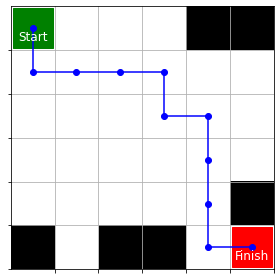

In [54]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic
  

#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")